#### Импортируем необходимые модули

In [1]:
import os
import glob
import random
import xml.etree.ElementTree as ET

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

import timm  # Используем ResNet-50
from pytorch_metric_learning.losses import ArcFaceLoss
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

C:\Users\zacgr\Documents\GitReps\VK_stazh\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Служебная функция для отображения картинок внутри ноутбука
from IPython.display import Markdown

def embed_image(filepath):
    import base64
    with open(filepath, "rb") as img_file:
        b64_string = base64.b64encode(img_file.read()).decode("utf-8")
        md_code = f"![Embedded Image](data:image/png;base64,{b64_string})"
        return Markdown(md_code)

#### Загрузим датасет и посмотрим на него

In [3]:
# Путь к корневой папке датасета
DATASET_PATH = "LogoDet-3K"

# Функция для поиска всех изображений и их аннотаций
def get_all_images_annotations(dataset_path):
    image_annotation_pairs = []
    
    # Рекурсивный обход всех категорий и подкаталогов
    for root, _, files in os.walk(dataset_path):
        image_files = {f for f in files if f.endswith('.jpg')}
        annotation_files = {f for f in files if f.endswith('.xml')}
        
        # Соединяем изображения и аннотации, учитывая их расположение в папках
        for img_file in image_files:
            img_id = img_file.split('.')[0]
            annotation_file = img_id + ".xml"

            if annotation_file in annotation_files:
                image_path = os.path.join(root, img_file)
                annotation_path = os.path.join(root, annotation_file)
                image_annotation_pairs.append((image_path, annotation_path))

    return image_annotation_pairs

# Функция для парсинга XML-аннотации
def parse_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    objects = []
    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        objects.append({"label": label, "bbox": (xmin, ymin, xmax, ymax)})
    
    return objects

# Функция для отображения изображения с аннотацией
def visualize_image_with_annotation(image_path, annotation_path):
    image = Image.open(image_path)
    annotations = parse_annotation(annotation_path)

    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.imshow(image)

    for ann in annotations:
        xmin, ymin, xmax, ymax = ann["bbox"]
        width, height = xmax - xmin, ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, ann["label"], fontsize=12, color='red', backgroundcolor="white")

    plt.axis("off")
    plt.title(f"Category: {os.path.basename(os.path.dirname(image_path))}")
    plt.show()

In [4]:
image_annotation_pairs = get_all_images_annotations(DATASET_PATH)

Выбрано изображение: LogoDet-3K\Food\cheeseburger in paradise\91.jpg
Аннотация: LogoDet-3K\Food\cheeseburger in paradise\91.xml


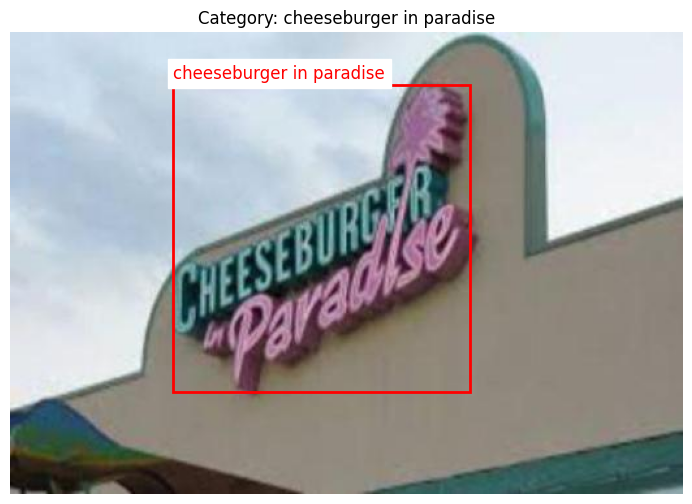

In [34]:
# Выбираем случайное изображение и его аннотацию
random_image, random_annotation = random.choice(image_annotation_pairs)

print(f"Выбрано изображение: {random_image}")
print(f"Аннотация: {random_annotation}")

visualize_image_with_annotation(random_image, random_annotation)

### Так как основная задача - распознавание "является ли логотип - искомым" то предположим, что детекция логотипа была проведена за нас и вынесем эту задачу в отдельный блок (если останется время)
 Для решения задачи сформируем новый датасет:  
 Он будет содержать логотипы, вырезанные по границе bounding box и приведённые к размеру 224 на 224 пикселя

In [5]:
# Параметры
DATASET_PATH = "LogoDet-3K"
OUTPUT_PATH = "Processed_LogoDet-3K"
IMG_SIZE = (224, 224)  # Размер логотипов после обрезки

In [31]:
# Функция для парсинга XML-аннотаций
def parse_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    objects = []
    for obj in root.findall("object"):
        label = obj.find("name").text  # Название бренда
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = map(int, [bbox.find("xmin").text, bbox.find("ymin").text, 
                                           bbox.find("xmax").text, bbox.find("ymax").text])
        objects.append({"label": label, "bbox": (xmin, ymin, xmax, ymax)})
    
    return objects

# Функция для вырезания логотипов
def extract_logos(dataset_path, output_path, img_size):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for root, _, files in os.walk(dataset_path):
        images = {f.split('.')[0]: os.path.join(root, f) for f in files if f.endswith('.jpg')}
        annotations = {f.split('.')[0]: os.path.join(root, f) for f in files if f.endswith('.xml')}
        
        for img_id, img_path in images.items():
            if img_id in annotations:
                annotation_path = annotations[img_id]
                image = Image.open(img_path)
                objects = parse_annotation(annotation_path)

                for i, obj in enumerate(objects):
                    xmin, ymin, xmax, ymax = obj["bbox"]
                    cropped_logo = image.crop((xmin, ymin, xmax, ymax))  # Вырезаем логотип
                    cropped_logo = cropped_logo.resize(img_size)  # Ресайз

                    # Создаём папку для бренда
                    brand_folder = os.path.join(output_path, obj["label"])
                    os.makedirs(brand_folder, exist_ok=True)

                    # Сохраняем обрезанное изображение
                    logo_path = os.path.join(brand_folder, f"{img_id}_{i}.jpg")
                    cropped_logo.save(logo_path)

extract_logos(DATASET_PATH, OUTPUT_PATH, IMG_SIZE)

print("✅ Логотипы успешно обработаны и сохранены в:", OUTPUT_PATH)

✅ Логотипы успешно обработаны и сохранены в: Processed_LogoDet-3K


### Создадим датасет
Он будет содержать картинки, метку класса (бренда) и текстовое название бренда

In [6]:
class LogoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.logo_paths = []
        self.labels = []
        self.brand_dict = {}

        # Загружаем все изображения
        brands = sorted(os.listdir(root_dir))
        for idx, brand in enumerate(brands):
            brand_path = os.path.join(root_dir, brand)
            images = glob.glob(os.path.join(brand_path, "*.jpg"))
            
            self.logo_paths.extend(images)
            self.labels.extend([idx] * len(images))
            self.brand_dict[idx] = brand  # Словарь {ID → Название бренда}

    def __len__(self):
        return len(self.logo_paths)

    def __getitem__(self, index):
        img_path = self.logo_paths[index]
        label = self.labels[index]
        image = Image.open(img_path).convert("RGB")
        label_str = self.brand_dict[label]

        if self.transform:
            image = self.transform(image)

        return image, label, label_str

# Аугментации и нормализация (для обеспечения инвариантности к поворотам и отражениям)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = LogoDataset(OUTPUT_PATH, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Проверяем
for images, labels, label_str in dataloader:
    print("Batch size:", images.shape, "Labels:", labels, "Label Str:", label_str)
    break

Batch size: torch.Size([32, 3, 224, 224]) Labels: tensor([2961, 1319,  135, 2500, 2585, 2474, 2265, 2347,  568, 1990,  830, 2019,
         438, 1305, 2559,  152, 1670, 1245, 2126, 2827,  154,  625,  127, 1977,
        1751, 2624, 2431, 1212,  146,  269,  237,  620]) Label Str: ('yurun', 'Market Pantry', "Aoki's Pizza", 'sk-ii', 'stein mart', 'showbiz pizza place', 'r. m. williams', 'rockshox', 'Celkon', 'neil pryde-1', "Fox's Biscuits", 'nivea', 'Buondi', 'Maille', 'speedway llc', 'Aral AG', 'kensie', 'LAVAZZA', 'perdolan', 'viru valge', "Arc'teryx", 'Chuck-A-Rama', "Angie's Kettle", 'nakamichi-2', 'liwayway', 'svedka', 'scotch and soda', 'Kibon', 'Appleton Estate', 'Bear Republic', 'Bacardi', 'Chrome Hearts')


### Построим модель
Основная идея - использовать Metric learning (направление машинного обучения, в котором алгоритм обучается строить такую функцию расстояния между объектами, которая лучше всего отражает их семантическую схожесть в контексте конкретной задачи).  
   
Эмбеддинги будем получать с помощью ArcFace (использует вложение (embedding) в нормализованное гиперсферическое пространство. Это значит, что вектора признаков, получаемые из нейросети, нормализуются и представляют точки на гиперсфере.)  
   
В качестве основы модели используем ResNet-50, заменим последний слой на линейный с выходной размерностью 512 и добавим ArcFace Loss.

In [7]:
class ArcFaceModel(nn.Module):
    def __init__(self, num_classes, embedding_size=512):
        super(ArcFaceModel, self).__init__()
        self.backbone = timm.create_model("resnet50", pretrained=True, num_classes=0)
        self.fc = nn.Linear(self.backbone.num_features, embedding_size)  # Последний слой
        self.arcface = ArcFaceLoss(num_classes, embedding_size, margin=0.5, scale=30)  # ArcFace Loss

    def forward(self, images, labels=None):
        embeddings = self.fc(self.backbone(images))
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        if labels is not None:
            return self.arcface(embeddings, labels), embeddings
        return embeddings

Запустим тестовое обучение, чтобы понять, работает ли такой подход

In [8]:
NUM_EPOCHS = 20
BATCH_SIZE = 32
EMBEDDING_SIZE = 512
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Количество классов (брендов)
num_classes = len(dataset.brand_dict)

model = ArcFaceModel(num_classes, EMBEDDING_SIZE).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

cuda


### Обучим модель

In [8]:
def train_model(model, dataloader, optimizer, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for images, labels, _ in progress:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            
            loss, embeddings = model(images, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress.set_postfix(loss=loss.item())
        
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}")

train_model(model, dataloader, optimizer, NUM_EPOCHS)

Epoch 1/20: 100%|██████████| 5661/5661 [27:45<00:00,  3.40it/s, loss=2.43]


Epoch 1: Loss = 4.6801


Epoch 2/20: 100%|██████████| 5661/5661 [17:52<00:00,  5.28it/s, loss=3.76] 


Epoch 2: Loss = 1.6231


Epoch 3/20: 100%|██████████| 5661/5661 [17:20<00:00,  5.44it/s, loss=1.77]  


Epoch 3: Loss = 0.9246


Epoch 4/20: 100%|██████████| 5661/5661 [17:20<00:00,  5.44it/s, loss=2.46]  


Epoch 4: Loss = 0.6057


Epoch 5/20: 100%|██████████| 5661/5661 [17:47<00:00,  5.30it/s, loss=3.87]  


Epoch 5: Loss = 0.4264


Epoch 6/20: 100%|██████████| 5661/5661 [17:50<00:00,  5.29it/s, loss=1.57]  


Epoch 6: Loss = 0.3045


Epoch 7/20: 100%|██████████| 5661/5661 [17:51<00:00,  5.28it/s, loss=3.03]  


Epoch 7: Loss = 0.2233


Epoch 8/20: 100%|██████████| 5661/5661 [17:57<00:00,  5.25it/s, loss=1.99]  


Epoch 8: Loss = 0.1639


Epoch 9/20: 100%|██████████| 5661/5661 [17:54<00:00,  5.27it/s, loss=5.32]  


Epoch 9: Loss = 0.1234


Epoch 10/20: 100%|██████████| 5661/5661 [17:51<00:00,  5.28it/s, loss=2.26]  


Epoch 10: Loss = 0.0944


Epoch 11/20: 100%|██████████| 5661/5661 [29:13<00:00,  3.23it/s, loss=2.53]    


Epoch 11: Loss = 0.0747


Epoch 12/20:  51%|█████     | 2900/5661 [15:07<14:24,  3.20it/s, loss=0.026]  


KeyboardInterrupt: 

### Видно, что модель учится и лосс уменьшается, теперь проверим расстояние между эмбеддингами картинок, которые нейросеть никогда не видела

Логотипы одного и того же бренда:

In [9]:
def compare_logos(model, image1, image2):
    """
    Сравниваем два логотипа через косинусное сходство
    """
    model.eval()
    
    image1 = transform(image1).unsqueeze(0).to(DEVICE)
    image2 = transform(image2).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        emb1 = model(image1)
        emb2 = model(image2)
    
    similarity = cosine_similarity(emb1.cpu(), emb2.cpu())
    return similarity[0][0]

img1 = Image.open("val_dir/18_0.jpg")
img2 = Image.open("val_dir/1_0.jpg")

score = compare_logos(model, img1, img2)
print(f"Сходство логотипов: {score:.4f}")

Сходство логотипов: 0.3754


Логотипы разных брендов:

In [10]:
img1 = Image.open("val_dir/18_0.jpg")
img2 = Image.open("val_dir/2_0.jpg")

score = compare_logos(model, img1, img2)
print(f"Сходство логотипов: {score:.4f}")

Сходство логотипов: -0.0190


In [11]:
img1 = Image.open("val_dir/18_0.jpg")
img2 = Image.open("val_dir/59_0.jpg")

score = compare_logos(model, img1, img2)
print(f"Сходство логотипов: {score:.4f}")

Сходство логотипов: 0.0465


Как можно заметить значение для одного бренда отличается на порядок. Т.е. мы двигаемся в нужном направлении.

In [12]:
torch.save(model, "full_model_1.pth")

### Доработка и отладка
Теперь поступим "по-взрослому" и разделим наш датасет на обучающую и тестовую выборки.  
Делить будем таким образом, чтобы в обучающей и тестовой выборке были представлены все классы (бренды).

In [9]:
# Извлекаем все метки классов
all_labels = [dataset[i][1] for i in range(len(dataset))]  # dataset[i][1] - метка класса

# Разделяем индексы данных
train_indices, test_indices = train_test_split(
    np.arange(len(dataset)), test_size=0.2, stratify=all_labels, random_state=42)


train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Обучающая выборка (стратифицированная): {len(train_dataset)} примеров")
print(f"Тестовая выборка (стратифицированная): {len(test_dataset)} примеров")

Обучающая выборка (стратифицированная): 144895 примеров
Тестовая выборка (стратифицированная): 36224 примеров


### Для повышения качества разделения применим hard mining (приближаем разные эмбеддинги одного класса и отдаляем одинаковые эмбеддинги разных классов). 
Общий лосс будет высчитывать таким образом:  
Итоговый loss = ArcFace loss + lambda_triplet * Triplet Loss,  
где lambda_triplet -- некоторый коэффициент.

In [10]:
def compute_triplet_loss(embeddings, labels, margin=0.5):
    """
    embeddings: тензор размером (batch_size, embedding_dim)
    labels: тензор с метками классов размером (batch_size,)
    margin: отступ в Triplet Loss
    """
    batch_size = embeddings.size(0)
    
    # Преобразуем эмбеддинги и метки в numpy для вычисления матрицы сходства
    emb_np = embeddings.detach().cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    # Вычисляем матрицу косинусного сходства для всего батча (размер: batch_size x batch_size)
    similarity_matrix = cosine_similarity(emb_np)
    
    triplet_losses = []
    
    # Для каждого примера (anchor) выбираем hard positive и hard negative из батча
    for i in range(batch_size):
        anchor = embeddings[i]
        label_anchor = labels_np[i]
        
        # Находим индексы позитивных примеров (те, у кого метка равна якорю, кроме самого якоря)
        pos_indices = np.where(labels_np == label_anchor)[0]
        pos_indices = pos_indices[pos_indices != i]
        
        # Находим индексы негативных примеров (те, у кого метка отличается)
        neg_indices = np.where(labels_np != label_anchor)[0]
        
        if len(pos_indices) == 0 or len(neg_indices) == 0:
            # Если для данного примера невозможно сформировать тройку, пропускаем его
            continue
        
        # Hard Positive: выбираем из позитивов тот, у которого косинусное сходство с якорем минимально
        pos_sims = similarity_matrix[i, pos_indices]
        hardest_pos_idx = pos_indices[np.argmin(pos_sims)]
        
        # Hard Negative: выбираем из негативов тот, у которого сходство с якорем максимально
        neg_sims = similarity_matrix[i, neg_indices]
        hardest_neg_idx = neg_indices[np.argmax(neg_sims)]
        
        # Извлекаем эмбеддинги hard positive и hard negative
        hard_pos = embeddings[hardest_pos_idx]
        hard_neg = embeddings[hardest_neg_idx]
        
        # Вычисляем евклидовы расстояния
        pos_distance = F.pairwise_distance(anchor.unsqueeze(0), hard_pos.unsqueeze(0))
        neg_distance = F.pairwise_distance(anchor.unsqueeze(0), hard_neg.unsqueeze(0))
        
        # Triplet Loss для данного якоря
        loss_i = F.relu(pos_distance - neg_distance + margin)
        triplet_losses.append(loss_i)
    
    if len(triplet_losses) == 0:
        return torch.tensor(0.0, requires_grad=True, device=embeddings.device)
    
    # Усредняем потери по всем образцам батча
    triplet_loss = torch.mean(torch.stack(triplet_losses))
    return triplet_loss

### Изменим также train loop в соответствии с данной идеей и добавим логирование обучения в Tensorboard.

In [11]:
def train_model(model, train_loader, test_loader, optimizer, num_epochs, device, lambda_triplet=0.5, log_dir="runs/arcface_experiment"):
    writer = SummaryWriter(log_dir=log_dir)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for images, labels, _ in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Вычисляем основную ArcFace loss и получаем эмбеддинги
            loss_arcface, embeddings = model(images, labels)
            # Вычисляем дополнительную Triplet Loss с hard mining
            loss_triplet = compute_triplet_loss(embeddings, labels, margin=0.5)
            
            # Итоговый loss = ArcFace loss + lambda_triplet * Triplet Loss
            total_batch_loss = loss_arcface + lambda_triplet * loss_triplet
            total_batch_loss.backward()
            optimizer.step()
            
            total_loss += total_batch_loss.item()
            num_batches += 1
            progress_bar.set_postfix(loss=total_batch_loss.item())
        
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        
        writer.add_scalar("Loss/train", avg_loss, epoch)
        
        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0
            val_batches = 0
            for images, labels, _ in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                loss_arcface, embeddings = model(images, labels)
                loss_triplet = compute_triplet_loss(embeddings, labels, margin=0.5)
                loss_val = loss_arcface + lambda_triplet * loss_triplet
                total_val_loss += loss_val.item()
                val_batches += 1
            avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0.0
            writer.add_scalar("Loss/val", avg_val_loss, epoch)
            print(f"Validation Loss: {avg_val_loss:.4f}")
    
    writer.close()
    print("Training complete.")

In [17]:
num_classes = len(dataset.brand_dict)
model = ArcFaceModel(num_classes, embedding_size=512).to(DEVICE)

LEARNING_RATE = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

NUM_EPOCHS = 10
LAMBDA_TRIPLET = 0.5

train_model(model, train_loader, test_loader, optimizer, NUM_EPOCHS, DEVICE, lambda_triplet=LAMBDA_TRIPLET, log_dir="runs/arcface_experiment_2")

Epoch 1/10: 100%|██████████| 4528/4528 [13:57<00:00,  5.40it/s, loss=1.59]


Epoch 1/10, Average Loss: 5.1796
Validation Loss: 2.5849


Epoch 2/10: 100%|██████████| 4528/4528 [13:53<00:00,  5.43it/s, loss=2.1]  


Epoch 2/10, Average Loss: 1.9710
Validation Loss: 1.4495


Epoch 3/10: 100%|██████████| 4528/4528 [13:51<00:00,  5.45it/s, loss=0.915]


Epoch 3/10, Average Loss: 1.1515
Validation Loss: 1.0563


Epoch 4/10: 100%|██████████| 4528/4528 [13:52<00:00,  5.44it/s, loss=0.518] 


Epoch 4/10, Average Loss: 0.7735
Validation Loss: 0.8718


Epoch 5/10: 100%|██████████| 4528/4528 [13:53<00:00,  5.43it/s, loss=0.391] 


Epoch 5/10, Average Loss: 0.5530
Validation Loss: 0.7519


Epoch 6/10: 100%|██████████| 4528/4528 [13:48<00:00,  5.46it/s, loss=0.318] 


Epoch 6/10, Average Loss: 0.4080
Validation Loss: 0.6803


Epoch 7/10: 100%|██████████| 4528/4528 [13:42<00:00,  5.50it/s, loss=0.244] 


Epoch 7/10, Average Loss: 0.3087
Validation Loss: 0.6218


Epoch 8/10: 100%|██████████| 4528/4528 [13:48<00:00,  5.47it/s, loss=0.228] 


Epoch 8/10, Average Loss: 0.2326
Validation Loss: 0.5839


Epoch 9/10: 100%|██████████| 4528/4528 [13:48<00:00,  5.46it/s, loss=0.145] 


Epoch 9/10, Average Loss: 0.1804
Validation Loss: 0.5622


Epoch 10/10: 100%|██████████| 4528/4528 [13:46<00:00,  5.48it/s, loss=0.123]  


Epoch 10/10, Average Loss: 0.1425
Validation Loss: 0.5429
Training complete.


### Логи Tensorboard

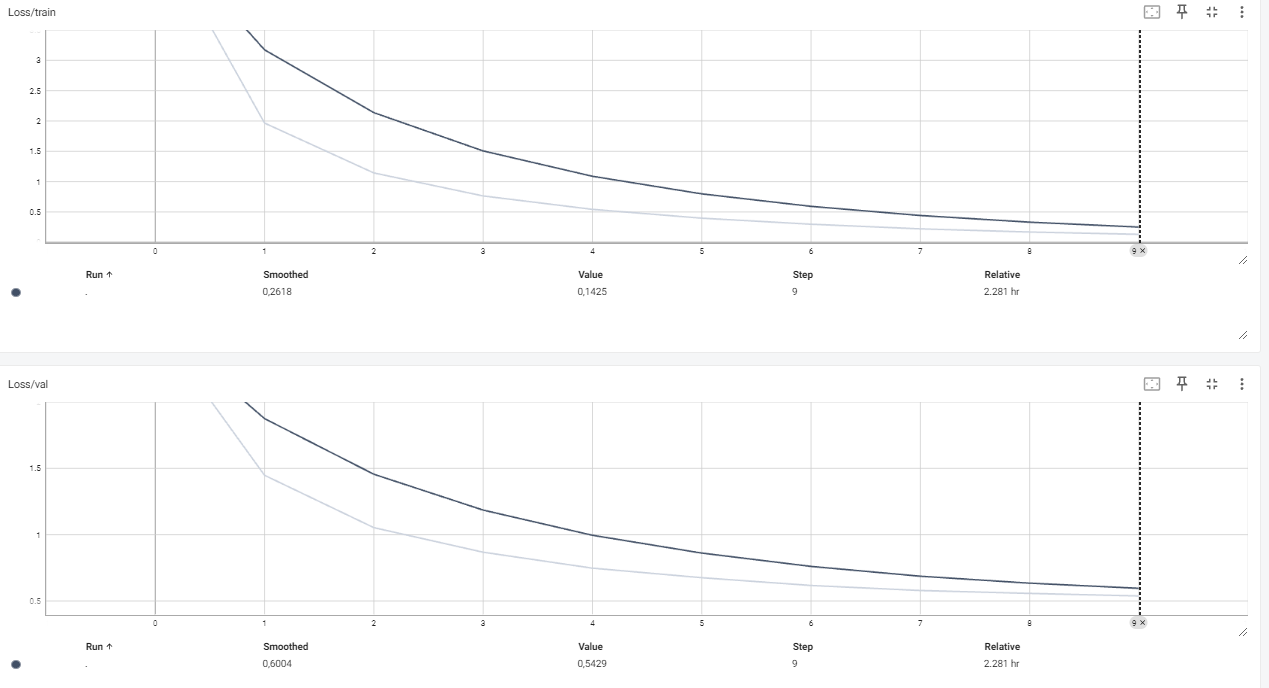

In [41]:
embed_image("images/training.png")

In [18]:
torch.save(model, "full_model_2_triplet.pth")

In [19]:
torch.save(model.state_dict(), "model_2_triplet_weights.pth")

### Как можно заметить, лосс постоянно уменьшался и даже переобучения мы так и не достигли
Посмотрим на те же заведомо известные картинки. Для оценки принадлежности к одному классу используем пороговое значение косинусной близости (threshold), подберём его эмпирически.

In [12]:
def get_embedding(model, image, transform, device):
    """
    Принимает:
      - model: обученная модель, которая на входе принимает изображение и возвращает эмбеддинг.
      - image: PIL.Image, входное изображение.
      - transform: преобразования, используемые при обучении (чтобы привести изображение к нужному формату).
      - device: устройство (CPU или CUDA).
    
    Возвращает:
      - эмбеддинг размерности (1, embedding_dim)
    """
    model.eval()
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Вызов модели без меток (labels=None) должен возвращать только эмбеддинг
        output = model(image_tensor)
        # Если модель возвращает кортеж, где первый элемент — loss, а второй — эмбеддинг,
        # то при отсутствии меток модель должна вернуть только эмбеддинг.
        if isinstance(output, tuple):
            embedding = output[1]
        else:
            embedding = output
    return embedding


In [13]:
def compare_images(model, image1, image2, transform, device, threshold=0.8):
    """
    Принимает:
      - model: обученная модель (ArcFaceModel)
      - image1, image2: два изображения в формате PIL.Image
      - transform: те же преобразования, что использовались при обучении
      - device: устройство (CPU или CUDA)
      - threshold: пороговое значение для косинусного сходства, выше которого считаем, что изображения принадлежат одному классу
      
    Возвращает:
      - similarity: вычисленное косинусное сходство (число от -1 до 1)
      - same_class: булево значение, True если similarity > threshold, иначе False
    """
    embedding1 = get_embedding(model, image1, transform, device)
    embedding2 = get_embedding(model, image2, transform, device)
    
    # Вычисляем косинусное сходство между эмбеддингами
    similarity = F.cosine_similarity(embedding1, embedding2).item()
    
    # Если similarity выше порога, считаем, что изображения принадлежат одному классу
    same_class = similarity > threshold
    return similarity, same_class


In [36]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)


image1 = Image.open("val_dir/18_0.jpg").convert("RGB")
image2 = Image.open("val_dir/1_0.jpg").convert("RGB")

# Задаём пороговое значение.
threshold = 0.2

similarity, same_class = compare_images(model, image1, image2, transform, DEVICE, threshold=threshold)

print(f"Косинусное сходство: {similarity:.4f}")
if same_class:
    print("Изображения принадлежат одному классу.")
else:
    print("Изображения принадлежат разным классам.")

Косинусное сходство: 0.3418
Изображения принадлежат одному классу.


In [27]:
# Загружаем два изображения
image1 = Image.open("val_dir/18_0.jpg").convert("RGB")
image2 = Image.open("val_dir/2_0.jpg").convert("RGB")

# Задаём пороговое значение.
threshold = 0.2

similarity, same_class = compare_images(model, image1, image2, transform, DEVICE, threshold=threshold)

print(f"Косинусное сходство: {similarity:.4f}")
if same_class:
    print("Изображения принадлежат одному классу.")
else:
    print("Изображения принадлежат разным классам.")


Косинусное сходство: 0.0190
Изображения принадлежат разным классам.


In [37]:
# Загружаем два изображения
image1 = Image.open("val_dir/18_0.jpg").convert("RGB")
image2 = Image.open("val_dir/59_0.jpg").convert("RGB")

# Задаём пороговое значение.
threshold = 0.2

similarity, same_class = compare_images(model, image1, image2, transform, DEVICE, threshold=threshold)

print(f"Косинусное сходство: {similarity:.4f}")
if same_class:
    print("Изображения принадлежат одному классу.")
else:
    print("Изображения принадлежат разным классам.")


Косинусное сходство: -0.0275
Изображения принадлежат разным классам.


Как видно, разница между логотипами одного и того же бренда почти не изменилась, а между логотипами разных брендов - увеличилась. Это хороший и правильный результат.

### Теперь наглядно посмотрим на оценку модели на тестовом датасете и уточним значение threshold.

In [14]:
def get_embedding(model, image, transform, device):
    model.eval()
    if isinstance(image, torch.Tensor):
        image = ToPILImage()(image.cpu())
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        if isinstance(output, tuple):
            embedding = output[1]
        else:
            embedding = output
    return embedding


def compare_images(model, image1, image2, transform, device, threshold=0.8):
    embedding1 = get_embedding(model, image1, transform, device)
    embedding2 = get_embedding(model, image2, transform, device)
    similarity = F.cosine_similarity(embedding1, embedding2).item()
    same_class = similarity > threshold
    return similarity, same_class


def visualize_pair(anchor_img, candidate_img, anchor_label_str, candidate_label_str, similarity, prediction):
    to_pil = ToPILImage()
    if isinstance(anchor_img, torch.Tensor):
        anchor_img = to_pil(anchor_img.cpu())
    if isinstance(candidate_img, torch.Tensor):
        candidate_img = to_pil(candidate_img.cpu())
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(anchor_img)
    axes[0].axis("off")
    axes[0].set_title(f"Anchor: ({anchor_label_str})")
    
    axes[1].imshow(candidate_img)
    axes[1].axis("off")
    axes[1].set_title(f"Candidate: ({candidate_label_str})")
    
    plt.suptitle(f"Cosine similarity: {similarity:.4f} | Prediction: {'Same' if prediction else 'Different'}")
    plt.show()

Выбранное изображение (anchor): Ceceba
Сравнения с кандидатами того же класса:


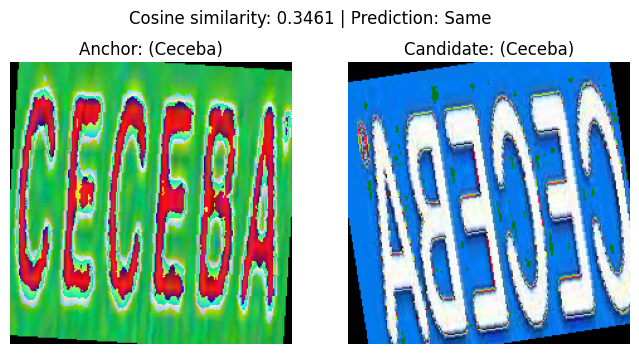

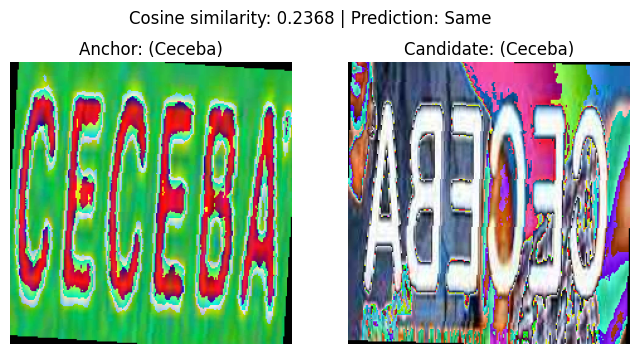

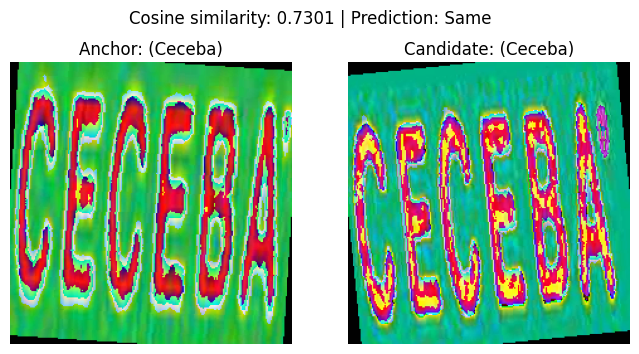

Сравнения с кандидатами другого класса:


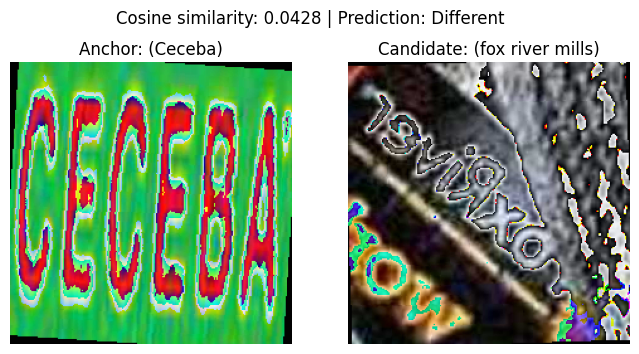

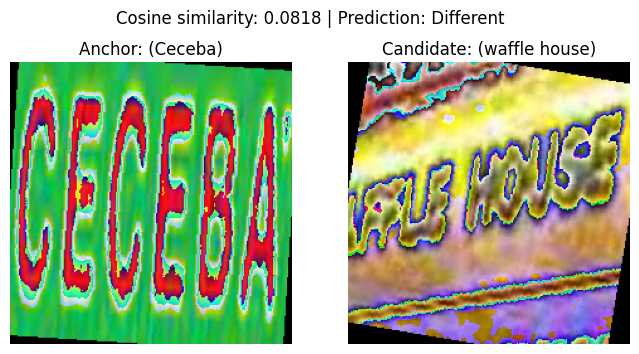

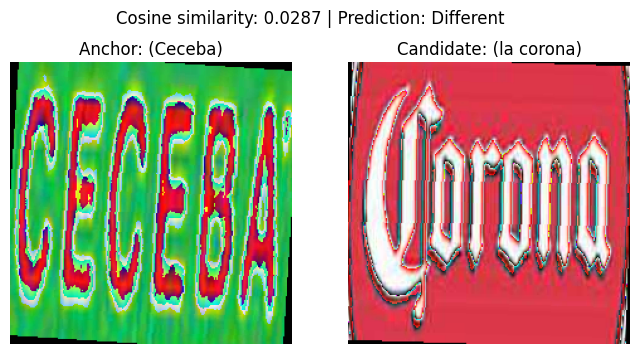

In [33]:
# Выбираем случайное изображение (anchor) из тестового датасета
# test_dataset должен возвращать кортеж: (image, label, label_str)
anchor_idx = random.randint(0, len(test_dataset) - 1)
anchor_img, anchor_label, anchor_label_str = test_dataset[anchor_idx]

print(f"Выбранное изображение (anchor): {anchor_label_str}")

# выберем несколько изображений того же класса и нескольких другого класса
same_class_candidates = []
diff_class_candidates = []

# Перебирём тестовый датасет и собираем кандидатов (пропускаем сам якорь)
for i in range(len(test_dataset)):
    if i == anchor_idx:
        continue
    img, lbl, lbl_str = test_dataset[i]
    if lbl == anchor_label:
        same_class_candidates.append((img, lbl, lbl_str))
    else:
        diff_class_candidates.append((img, lbl, lbl_str))

# Выбирем случайно по 3 кандидата из каждой группы (если достаточно примеров)
num_candidates = 3
same_class_samples = random.sample(same_class_candidates, min(num_candidates, len(same_class_candidates)))
diff_class_samples = random.sample(diff_class_candidates, min(num_candidates, len(diff_class_candidates)))


print("Сравнения с кандидатами того же класса:")
for candidate in same_class_samples:
    cand_img, cand_lbl, cand_lbl_str = candidate
    similarity, pred = compare_images(model, anchor_img, cand_img, transform, DEVICE, threshold=0.16)
    visualize_pair(anchor_img, cand_img, anchor_label_str, cand_lbl_str, similarity, pred)
    
print("Сравнения с кандидатами другого класса:")
for candidate in diff_class_samples:
    cand_img, cand_lbl, cand_lbl_str = candidate
    similarity, pred = compare_images(model, anchor_img, cand_img, transform, DEVICE, threshold=0.16)
    visualize_pair(anchor_img, cand_img, anchor_label_str, cand_lbl_str, similarity, pred)

Выбранное изображение (anchor): Havells
Сравнения с кандидатами того же класса:


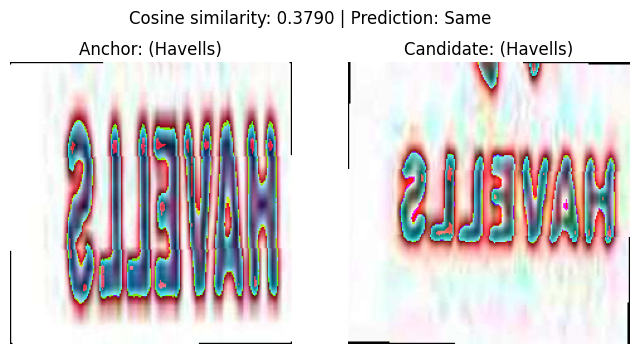

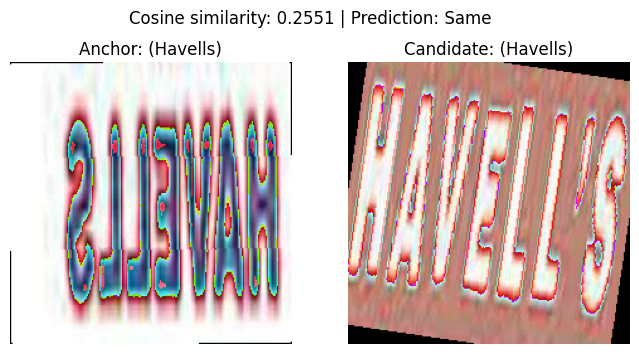

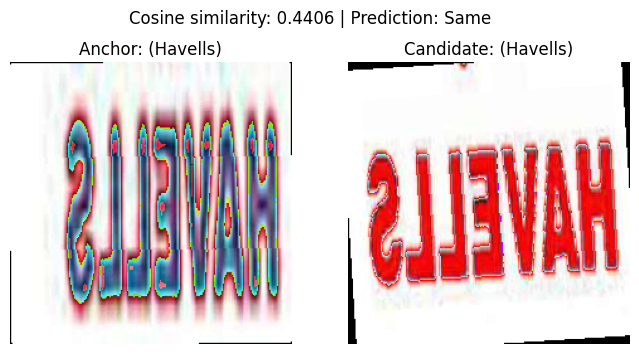

Сравнения с кандидатами другого класса:


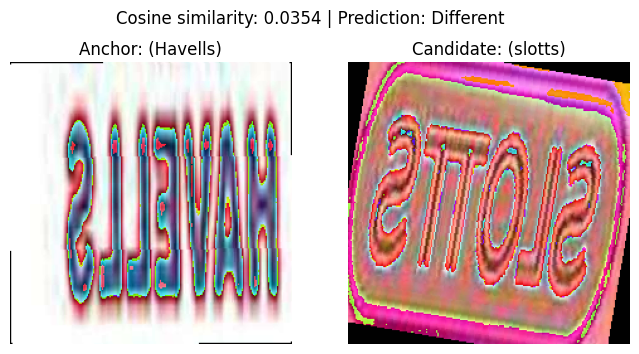

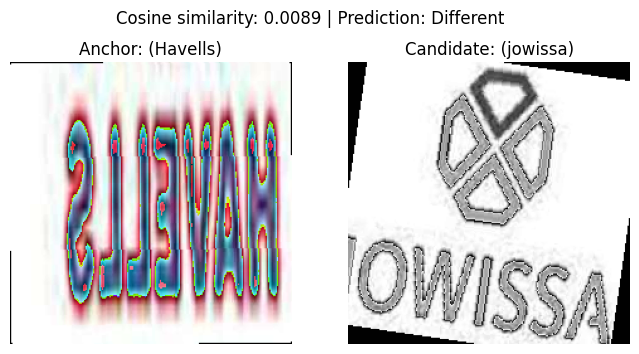

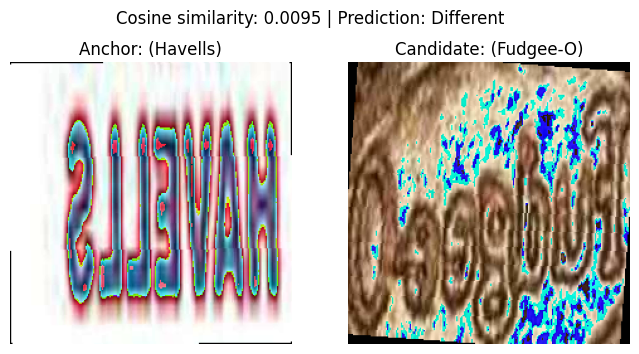

In [38]:
# Выбираем случайное изображение (anchor) из тестового датасета
# test_dataset должен возвращать кортеж: (image, label, label_str)
anchor_idx = random.randint(0, len(test_dataset) - 1)
anchor_img, anchor_label, anchor_label_str = test_dataset[anchor_idx]

print(f"Выбранное изображение (anchor): {anchor_label_str}")

# выберем несколько изображений того же класса и нескольких другого класса
same_class_candidates = []
diff_class_candidates = []

# Перебирём тестовый датасет и собираем кандидатов (пропускаем сам якорь)
for i in range(len(test_dataset)):
    if i == anchor_idx:
        continue
    img, lbl, lbl_str = test_dataset[i]
    if lbl == anchor_label:
        same_class_candidates.append((img, lbl, lbl_str))
    else:
        diff_class_candidates.append((img, lbl, lbl_str))

# Выбирем случайно по 3 кандидата из каждой группы (если достаточно примеров)
num_candidates = 3
same_class_samples = random.sample(same_class_candidates, min(num_candidates, len(same_class_candidates)))
diff_class_samples = random.sample(diff_class_candidates, min(num_candidates, len(diff_class_candidates)))

print("Сравнения с кандидатами того же класса:")
for candidate in same_class_samples:
    cand_img, cand_lbl, cand_lbl_str = candidate
    similarity, pred = compare_images(model, anchor_img, cand_img, transform, DEVICE, threshold=0.16)
    visualize_pair(anchor_img, cand_img, anchor_label_str, cand_lbl_str, similarity, pred)

print("Сравнения с кандидатами другого класса:")
for candidate in diff_class_samples:
    cand_img, cand_lbl, cand_lbl_str = candidate
    similarity, pred = compare_images(model, anchor_img, cand_img, transform, DEVICE, threshold=0.16)
    visualize_pair(anchor_img, cand_img, anchor_label_str, cand_lbl_str, similarity, pred)


Выбранное изображение (anchor): thomapyrin
Сравнения с кандидатами того же класса:


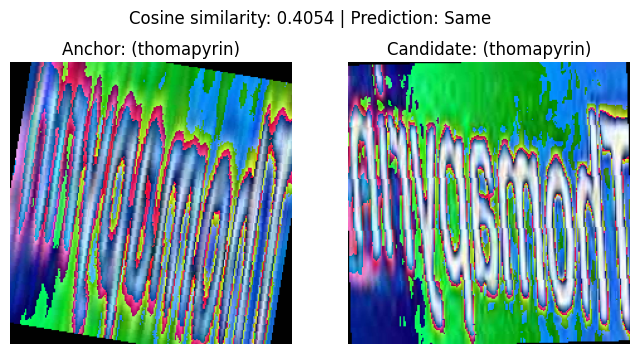

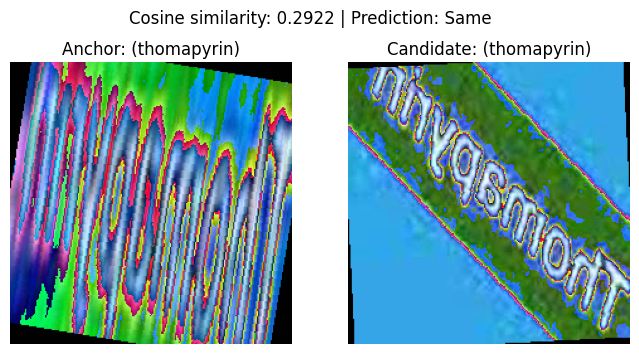

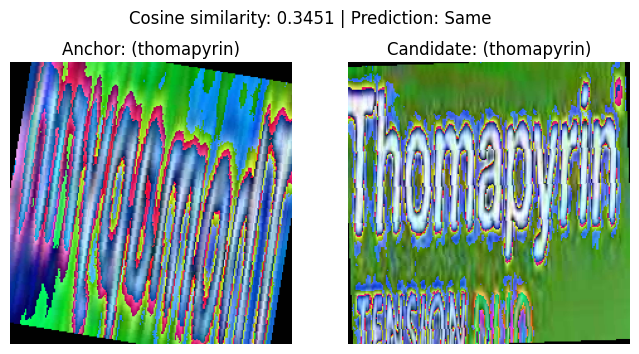

Сравнения с кандидатами другого класса:


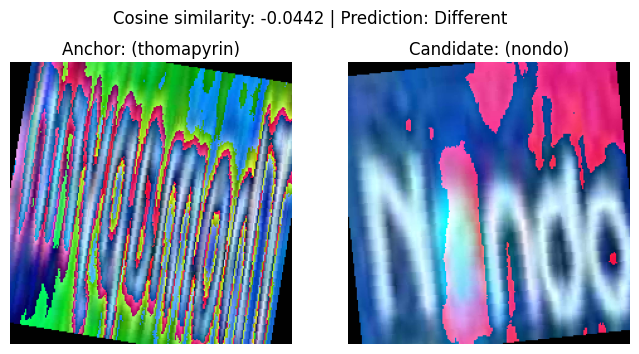

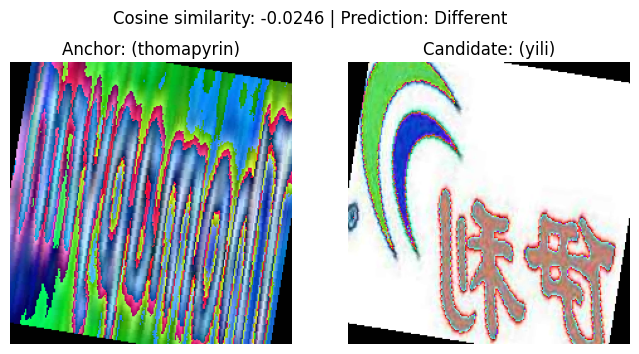

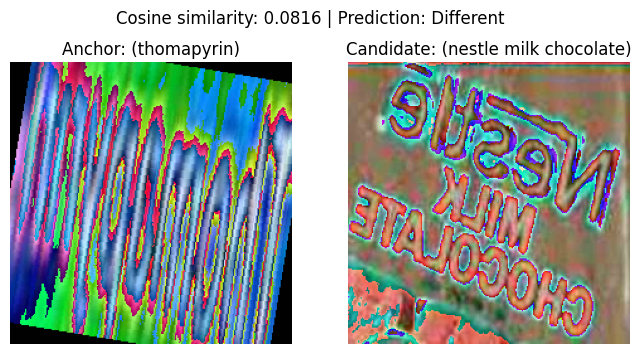

In [39]:
# Выбираем случайное изображение (anchor) из тестового датасета
# test_dataset должен возвращать кортеж: (image, label, label_str)
anchor_idx = random.randint(0, len(test_dataset) - 1)
anchor_img, anchor_label, anchor_label_str = test_dataset[anchor_idx]

print(f"Выбранное изображение (anchor): {anchor_label_str}")

# выберем несколько изображений того же класса и нескольких другого класса
same_class_candidates = []
diff_class_candidates = []

# Перебирём тестовый датасет и собираем кандидатов (пропускаем сам якорь)
for i in range(len(test_dataset)):
    if i == anchor_idx:
        continue
    img, lbl, lbl_str = test_dataset[i]
    if lbl == anchor_label:
        same_class_candidates.append((img, lbl, lbl_str))
    else:
        diff_class_candidates.append((img, lbl, lbl_str))

# Выбирем случайно по 3 кандидата из каждой группы (если достаточно примеров)
num_candidates = 3
same_class_samples = random.sample(same_class_candidates, min(num_candidates, len(same_class_candidates)))
diff_class_samples = random.sample(diff_class_candidates, min(num_candidates, len(diff_class_candidates)))

print("Сравнения с кандидатами того же класса:")
for candidate in same_class_samples:
    cand_img, cand_lbl, cand_lbl_str = candidate
    similarity, pred = compare_images(model, anchor_img, cand_img, transform, DEVICE, threshold=0.16)
    visualize_pair(anchor_img, cand_img, anchor_label_str, cand_lbl_str, similarity, pred)

print("Сравнения с кандидатами другого класса:")
for candidate in diff_class_samples:
    cand_img, cand_lbl, cand_lbl_str = candidate
    similarity, pred = compare_images(model, anchor_img, cand_img, transform, DEVICE, threshold=0.16)
    visualize_pair(anchor_img, cand_img, anchor_label_str, cand_lbl_str, similarity, pred)


### Как можно заметить с threshold = 0.16 Качество распознавание достаточно хорошее.

In [45]:
model.load_state_dict(torch.load("model_2_triplet_weights.pth"))

<All keys matched successfully>

### Для того, чтобы оценить качество работы и ещё больше уточнить пороговое значение threshold, соберём датасет пар картинок и посчитаем на нем f1-score.

In [53]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [15]:
# Формируем датасет пар, используя индексы
# test_dataset возвращает (image, label, label_str)
# Создаем словарь: метка -> список индексов
label_to_indices = {}
for idx in range(len(test_dataset)):
    _, label, _ = test_dataset[idx]
    label_to_indices.setdefault(label, []).append(idx)

positive_pairs = []
# Для каждой метки формируем позитивные пары, но выбираем максимум 10 пар
for label, indices in label_to_indices.items():
    if len(indices) >= 2:
        possible_pairs = []
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                possible_pairs.append((indices[i], indices[j]))
        num_to_sample = min(10, len(possible_pairs))
        positive_pairs.extend(random.sample(possible_pairs, num_to_sample))

# Формируем негативные пары: выбираем случайные пары индексов с разными метками,
# ограничиваем общее число негативных пар равным количеству позитивных
all_indices = list(range(len(test_dataset)))
negative_pairs = []
while len(negative_pairs) < len(positive_pairs):
    i, j = random.sample(all_indices, 2)
    _, label_i, _ = test_dataset[i]
    _, label_j, _ = test_dataset[j]
    if label_i != label_j:
        negative_pairs.append((i, j))

print(f"Positive pairs: {len(positive_pairs)}, Negative pairs: {len(negative_pairs)}")

# Формируем общий датасет пар в виде списка кортежей: (index1, index2, true_label)
pairs_indices_dataset = []
for (i, j) in positive_pairs:
    pairs_indices_dataset.append((i, j, 1))
for (i, j) in negative_pairs:
    pairs_indices_dataset.append((i, j, 0))

Positive pairs: 25227, Negative pairs: 25227


#### Вычисляем f1-score для разных значений threshold

In [17]:
predictions = []
true_labels = []

for idx1, idx2, true_label in pairs_indices_dataset:
    img1, _, _ = test_dataset[idx1]
    img2, _, _ = test_dataset[idx2]
    similarity, pred = compare_images(model, img1, img2, transform, DEVICE, threshold=0.16)
    predictions.append(1 if pred else 0)
    true_labels.append(true_label)

f1 = f1_score(true_labels, predictions)
print("F1 Score:", f1)

F1 Score: 0.6668164576201742


In [21]:
predictions = []
true_labels = []

for idx1, idx2, true_label in pairs_indices_dataset:
    img1, _, _ = test_dataset[idx1]
    img2, _, _ = test_dataset[idx2]
    similarity, pred = compare_images(model, img1, img2, transform, DEVICE, threshold=0.2)
    predictions.append(1 if pred else 0)
    true_labels.append(true_label)

f1 = f1_score(true_labels, predictions)
print("F1 Score:", f1)

F1 Score: 0.6671605852935729


In [22]:
predictions = []
true_labels = []

for idx1, idx2, true_label in pairs_indices_dataset:
    img1, _, _ = test_dataset[idx1]
    img2, _, _ = test_dataset[idx2]
    similarity, pred = compare_images(model, img1, img2, transform, DEVICE, threshold=0.3)
    predictions.append(1 if pred else 0)
    true_labels.append(true_label)

f1 = f1_score(true_labels, predictions)
print("F1 Score:", f1)

F1 Score: 0.6756822744289512


In [23]:
predictions = []
true_labels = []

for idx1, idx2, true_label in pairs_indices_dataset:
    img1, _, _ = test_dataset[idx1]
    img2, _, _ = test_dataset[idx2]
    similarity, pred = compare_images(model, img1, img2, transform, DEVICE, threshold=0.4)
    predictions.append(1 if pred else 0)
    true_labels.append(true_label)

f1 = f1_score(true_labels, predictions)
print("F1 Score:", f1)

F1 Score: 0.7063076690364544


In [24]:
predictions = []
true_labels = []

for idx1, idx2, true_label in pairs_indices_dataset:
    img1, _, _ = test_dataset[idx1]
    img2, _, _ = test_dataset[idx2]
    similarity, pred = compare_images(model, img1, img2, transform, DEVICE, threshold=0.5)
    predictions.append(1 if pred else 0)
    true_labels.append(true_label)

f1 = f1_score(true_labels, predictions)
print("F1 Score:", f1)

F1 Score: 0.7311446317657497


In [25]:
predictions = []
true_labels = []

for idx1, idx2, true_label in pairs_indices_dataset:
    img1, _, _ = test_dataset[idx1]
    img2, _, _ = test_dataset[idx2]
    similarity, pred = compare_images(model, img1, img2, transform, DEVICE, threshold=0.6)
    predictions.append(1 if pred else 0)
    true_labels.append(true_label)

f1 = f1_score(true_labels, predictions)
print("F1 Score:", f1)

F1 Score: 0.6823970915914155


In [26]:
predictions = []
true_labels = []

for idx1, idx2, true_label in pairs_indices_dataset:
    img1, _, _ = test_dataset[idx1]
    img2, _, _ = test_dataset[idx2]
    similarity, pred = compare_images(model, img1, img2, transform, DEVICE, threshold=0.55)
    predictions.append(1 if pred else 0)
    true_labels.append(true_label)

f1 = f1_score(true_labels, predictions)
print("F1 Score:", f1)

F1 Score: 0.7234617142382318


In [27]:
predictions = []
true_labels = []

for idx1, idx2, true_label in pairs_indices_dataset:
    img1, _, _ = test_dataset[idx1]
    img2, _, _ = test_dataset[idx2]
    similarity, pred = compare_images(model, img1, img2, transform, DEVICE, threshold=0.45)
    predictions.append(1 if pred else 0)
    true_labels.append(true_label)

f1 = f1_score(true_labels, predictions)
print("F1 Score:", f1)

F1 Score: 0.72267766350342


### Как видно - первоначальное предположение о том, что threshold = 0.16 оказалось неверно. Самое оптимальное значение оказалось 0.5.
При нём f1-score = 0.73

In [28]:
def visualize_pair(img1, img2, true_label, similarity, prediction):
    to_pil = ToPILImage()
    if isinstance(img1, torch.Tensor):
        img1 = to_pil(img1.cpu())
    if isinstance(img2, torch.Tensor):
        img2 = to_pil(img2.cpu())
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img1)
    axes[0].axis("off")
    axes[0].set_title("Image 1")
    
    axes[1].imshow(img2)
    axes[1].axis("off")
    axes[1].set_title("Image 2")
    
    plt.suptitle(f"Similarity: {similarity:.4f} | True label: {true_label} | Predicted: {prediction}")
    plt.show()

Визуализируем случайные 5 картинок с threshold = 0.5

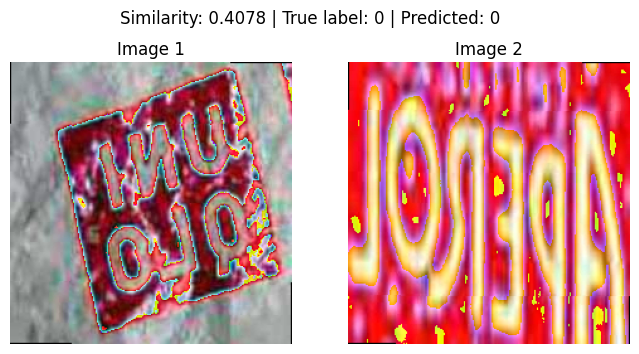

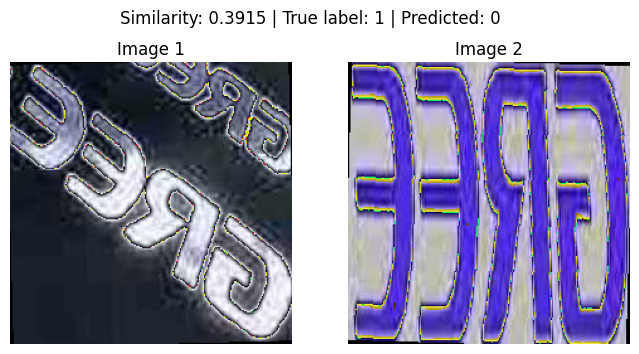

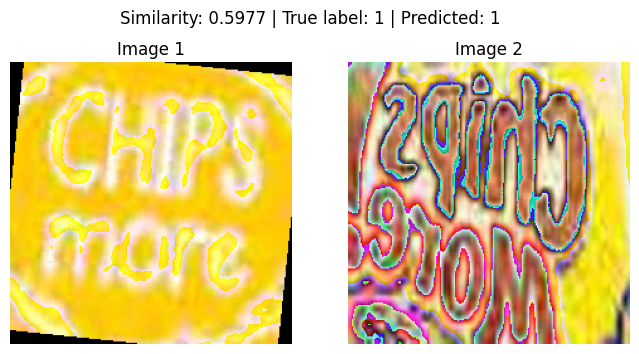

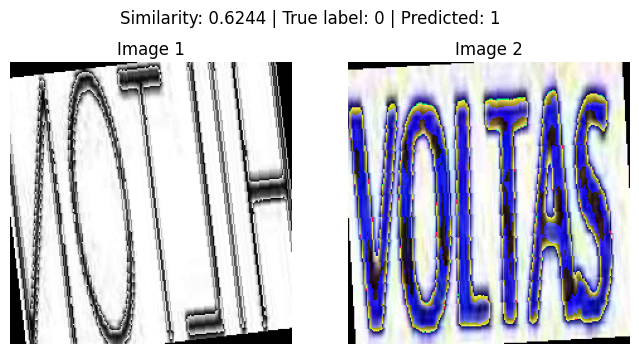

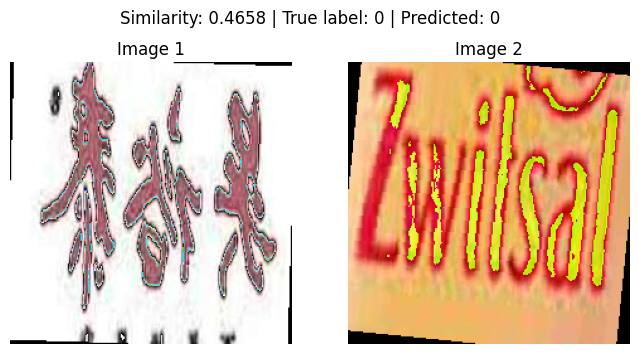

In [30]:
for _ in range(5):
    idx1, idx2, true_label = random.choice(pairs_indices_dataset)
    img1, _, _ = test_dataset[idx1]
    img2, _, _ = test_dataset[idx2]
    sim, pred_bool = compare_images(model, img1, img2, transform, DEVICE, threshold=0.5)
    pred_label = 1 if pred_bool else 0
    visualize_pair(img1, img2, true_label, sim, pred_label)

Как видно, получившаяся модель предсказывает одинаковый бренд достаточно хорошо, и что важно - инвариантна к деформациям, сдвигам и поворотам (на чём особенно сделан акцент в данной задаче).  
И всё же, результат не идеален. Возможности по улучшению качества, которые можно попробовать для данной задачи - это обучение на большем количестве эпох (мы ведь так и не достигли переобучения), также вместо (или дополнительно с) предсказанием по уровню косинусного расстояния использовать K-means, который можно обучить на эмбеддингах обучающей выборки, полученных после ArcFace-модели.  
  
В условии задачи было отмечено, что целевой логотип (с которым производится сравнение) может быть задан как картинкой, так и текстом. Для того, чтобы можно было задавать текстом, архитектуру модели нет необходимости сильно менять, достаточно иметь в доступе картинки целевого бренда и выбрать одну или несколько (для предсказания методом голосования) картинок логотипов и сравнивать уже с ними.